# Implementing Matrix Multiplication 

In this notebook I will explore several ways of implementing matrix multiplication while increasing performance

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [10]:
#export
from torch import tensor
import numpy
import pickle
import gzip
from urllib.request import urlopen
import matplotlib.pyplot as plt
import fastai.vision

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl.gz'

### Tests

In [3]:
#export
def test_eq(a, b): assert(a == b)

In [4]:
#export
def is_close(a, b, tol = 0): assert(abs(a-b) < tol)

### Preparing MNIST Data

In [14]:
f = gzip.open(urlopen(MNIST_URL), 'rb')
(train_x, train_y),_,_ = pickle.load(f, encoding='latin1')
f.close()

In [4]:
#export
def get_data():
    f = gzip.open(urlopen(MNIST_URL), 'rb')
    (train_x, train_y),(valid_x, valid_y),_ = pickle.load(f, encoding='latin1')
    f.close()
    train_x, train_y, valid_x, valid_y = map(tensor, (train_x, train_y, valid_x, valid_y))
    return train_x, train_y, valid_x, valid_y

In [34]:
train_x, train_y = map(tensor, (train_x, train_y))
train_x.shape, train_y.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [12]:
x_train, y_train, x_valid, y_valid = get_data()

In [35]:
test_eq(train_x.shape[0], train_y.shape[0])
assert(train_y.min() == 0)
assert(train_y.max() == 9)

tensor(5)

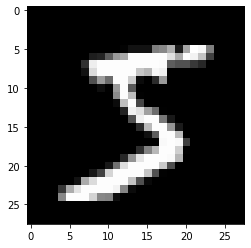

In [44]:
img = train_x[0]
plt.imshow(img.reshape(28,28), cmap='gray')
train_y[0]

### Matrix Multiplication Setup

In [296]:
m1 = train_x[:5]
torch.manual_seed(0)
m2 = torch.randn(784, 10)
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

### naive matmul

In [297]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i][j] += a[i][k] * b[k][j]
    return c
    

In [298]:
res = matmul(m1, m2)
act = torch.matmul(m1, m2)
torch.allclose(res, act, atol = 1e-3)

True

In [299]:
%timeit -n 10 t1 = matmul(m1, m2)

874 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### elementwise matmul

In [300]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i][j] = (a[i] * b[:, j]).sum()
    return c

In [301]:
res = matmul(m1, m2)
act = torch.matmul(m1, m2)
torch.allclose(res, act, atol = 1e-3)

True

In [302]:
%timeit -n 10 t2 = matmul(m1, m2)

1.18 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Broadcasting matmul

In [303]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(0)
    return c

In [304]:
res = matmul(m1, m2)
act = torch.matmul(m1, m2)
torch.allclose(res, act, atol = 1e-3)

True

In [305]:
%timeit -n 10 t3 = matmul(m1, m2)

222 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### einsum matmul

In [319]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert(ac == br)
    return torch.einsum('ik,kj->ij',a,b)

In [320]:
res = matmul(m1, m2)
act = torch.matmul(m1, m2)
torch.allclose(res, act, atol = 1e-3)

True

In [321]:
%timeit -n 10 t3 = matmul(m1, m2)

65.6 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### pytorch matmul

In [323]:
%timeit -n 10 t2 = m1.matmul(m2)

11.4 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [324]:
# time comparison vs pure python:
885000/18

49166.666666666664

## Conclusion

through various techniques we can greatly improve performance of matrix multiplication

In [5]:
!python nb2script.py matmul.ipynb

Converted matmul.ipynb to exp/nb_matmul.py
